In [3]:
#use this command to install the required packages 
!pip install -r requirements.txt 

In [4]:
#install these packages to get the resources you need
import pandas as pd
import numpy as np
import requests
import dask as dd
import seaborn as sns

In [5]:
%%time 
#here is the link to the file in Google Drive

# url_raw = 'https://drive.google.com/file/d/13vj4YxKRs1Tw1VPGhTefBxxKQuC5pRd_/view?usp=sharing'
# #url_raw_mn = 'https://drive.google.com/file/d/1YRh58UiKWNtxfvYa0IzFF3oYL42iBs7d/view?usp=sharing'
# req = requests.get(url_raw)
# url_content = req.content
# with open('test_data.csv',encoding="utf-8") as file:
#     df=pd.read_csv(file,delimiter=',')

df=pd.read_csv('test_data_v1.csv')

# req_mn = requests.get(url_raw_mn)
# url_content_mn = req_mn.content
# with open('test_data_mn.csv',) as file_mn:
#     df_mn=pd.read_csv(file_mn,delimiter=',')

Wall time: 3min 26s


In [6]:
#look at the properties of the two datasets 
print(df.head())
print(df.shape)


# print(df_mn.head())
# print(df_mn.shape)

   vb_voterbase_id vb_voterbase_household_id vb_tsmart_exact_address_track  \
0  AK-000000000020      Y000000186098323KYLE              Y000000186098323   
1  AK-000000000250    Y000000182911889OSWALD              Y000000182911889   
2  AK-000000000509    Y000000235819126HOLMES              Y000000235819126   
3  AK-000000000711     Y000000140159129SCOTT              Y000000140159129   
4  AK-000000001144    Y000000084251981LARSEN              Y000000084251981   

   vb_tsmart_latitude  vb_tsmart_longitude  vb_tsmart_zip vb_tsmart_state  \
0           61.095810          -149.828888          99516              AK   
1           61.184738          -149.751389          99504              AK   
2           48.383949          -115.551353          59923              MT   
3           61.319233          -149.532120          99577              AK   
4           61.423569          -149.480682          99567              AK   

  vb_tsmart_level      vb_tsmart_county_name  vb_tsmart_county_code 

In [7]:
df.columns

Index(['vb_voterbase_id', 'vb_voterbase_household_id',
       'vb_tsmart_exact_address_track', 'vb_tsmart_latitude',
       'vb_tsmart_longitude', 'vb_tsmart_zip', 'vb_tsmart_state',
       'vb_tsmart_level', 'vb_tsmart_county_name', 'vb_tsmart_county_code',
       'add_type', 'tsmart_geo_confidence', 'vb_voterbase_gender',
       'vb_voterbase_race', 'vb_education', 'tb_education_cd',
       'tb_college_age_flg', 'tb_starting_out_flg', 'tb_career_bldr_flg',
       'tb_prime_earner_flg', 'tb_retiree_flg', 'vb_occupation',
       'tb_occupation_cd', 'xpg_ind_lvl_occupation_code',
       'xpg_ind_lvl_occupation_group', 'hh_income', 'tb_income_range_prem_cd',
       'tb_income_amt', 'xpg_ind_lvl_business_owner',
       'vb_business_owner_indicator', 'vb_business_size_code',
       'vb_business_type', 'vb_business_revenue_range',
       'tb_business_owner_flg', 'tb_boah_flg', 'tb_boah_biz_size_cd',
       'tb_boah_biz_source_cd', 'tb_boah_biz_rank_cd', 'tb_boah_biz_func_cd',
       'tb_boa

# Data cleaning for Human Capital Project

First Goal: Create a column that identifies whether or not someone works in tech based upon a) their occupation status and/or b) working for/owning a company with a SIC code in the technology sector (i.e., any org with a code in the office of technology) 

In [8]:
# Data cleaning for test mn data, but can be motified for larger dataset (do not want to crash my laptop while testing)
##Need to create a binary column that identifies if someone is in tech
df.groupby('vb_occupation')['vb_occupation'].count()

vb_occupation
2     3621341
3      406126
5      943909
6     2478940
7     3009062
10    2094179
11     548167
13     219014
15     225486
17    2186340
18     834167
21     175299
38      61597
52      16049
Name: vb_occupation, dtype: int64

In [10]:
df['vb_occupation'].unique()

array([ 6,  2, 17, 18, 10,  7, 15,  3,  5, 13, 38, 52, 11, 21],
      dtype=int64)

In [11]:
df.groupby('tb_boah_biz_sic_cd')['tb_boah_biz_sic_cd'].count()
#834 different codes

tb_boah_biz_sic_cd
1.0       408047
111.0       2762
112.0        231
115.0      16239
116.0       2627
           ...  
9651.0       245
9661.0        34
9711.0       994
9721.0        98
9999.0     55611
Name: tb_boah_biz_sic_cd, Length: 1128, dtype: int64

In [12]:
df['tb_boah_biz_sic_cd'].astype(int, errors = 'ignore').astype(str).split('.')

AttributeError: 'Series' object has no attribute 'split'

In [13]:
df.groupby('tb_boah_biz_sic_2_cd')['tb_boah_biz_sic_2_cd'].count()
#89 different codes

tb_boah_biz_sic_2_cd
0.0     408047
1.0      12368
2.0       4426
7.0      16511
8.0        532
         ...  
94.0      2405
95.0      2622
96.0      2400
97.0      1228
99.0     55611
Name: tb_boah_biz_sic_2_cd, Length: 90, dtype: int64

In [14]:
# load in file with SIC codes
sic_codes=pd.read_excel('SIC_Codes_5.31.2021.xlsx')
sic_codes.columns

Index(['SIC Code', 'Office', 'Industry Title'], dtype='object')

#make a dictionary (First attempt)
sic_dict=sic_codes.to_dict('records')
sic_dict

In [15]:
# antoher type of dictionary that may be easier to manuver
sic_dict2=sic_codes.set_index('SIC Code').to_dict()['Office']
sic_dict2

{100: 'Office of Life Sciences',
 200: 'Office of Life Sciences',
 700: 'Office of Life Sciences',
 800: 'Office of Life Sciences',
 900: 'Office of Life Sciences',
 1000: 'Office of Energy & Transportation',
 1040: 'Office of Energy & Transportation',
 1090: 'Office of Energy & Transportation',
 1220: 'Office of Energy & Transportation',
 1221: 'Office of Energy & Transportation',
 1311: 'Office of Energy & Transportation',
 1381: 'Office of Energy & Transportation',
 1382: 'Office of Energy & Transportation',
 1389: 'Office of Energy & Transportation',
 1400: 'Office of Energy & Transportation',
 1520: 'Office of Real Estate & Construction',
 1531: 'Office of Real Estate & Construction',
 1540: 'Office of Real Estate & Construction',
 1600: 'Office of Real Estate & Construction',
 1623: 'Office of Real Estate & Construction',
 1700: 'Office of Real Estate & Construction',
 1731: 'Office of Real Estate & Construction',
 2000: 'Office of Manufacturing',
 2011: 'Office of Manufacturing'

In [17]:
#in the dataframe SIC Code is #.0 so the column needs to be clean
list_SIC_occ=[]
for occ_val in df['tb_boah_biz_sic_cd']:
    clean_val=str(occ_val).split('.')[0]
    list_SIC_occ.append(clean_val)
    
# add column with values

df['SIC_code']=df['tb_boah_biz_sic_cd'].map(sic_dict2)
df.head()
df['SIC_code'].unique()

array([nan, 'Office of Life Sciences', 'Office of Trade & Services',
       'Office of Real Estate & Construction', 'Office of Technology',
       'Office of Energy & Transportation', 'Office of Manufacturing',
       'Office of Finance', 'Office of International Corp Fin'],
      dtype=object)

In [44]:
#dictionary for occupation
occ_codes=target_smart['Field']=='vb.occupation'
occ_df=target_smart[occ_codes]
occ_df.drop(occ_df.index[[0]],inplace=True)
occ_df.head()

C:\Users\godin033\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


1,Field num,Field,Field Name,Field Description,Component,Component Description,Data Source,Field Value,Value Description,Distinct Count
2292,334,vb.occupation,IntelliBase Occupation Code,Indicates the occupation type of the individua...,VoterBase,TargetSmart's national voter file,Commercial,NaN,NaN,206981658
2293,334,vb.occupation,IntelliBase Occupation Code,Indicates the occupation type of the individua...,VoterBase,TargetSmart's national voter file,Commercial,2,Professional/Technical,10119959
2294,334,vb.occupation,IntelliBase Occupation Code,Indicates the occupation type of the individua...,VoterBase,TargetSmart's national voter file,Commercial,3,Upper Management/Executive,2802423
2295,334,vb.occupation,IntelliBase Occupation Code,Indicates the occupation type of the individua...,VoterBase,TargetSmart's national voter file,Commercial,5,Sales/Service,3254648
2296,334,vb.occupation,IntelliBase Occupation Code,Indicates the occupation type of the individua...,VoterBase,TargetSmart's national voter file,Commercial,6,Office/Clerical,5622736


In [45]:
occ_dict=occ_df.set_index('Field Value').to_dict()['Value Description']

In [46]:
df['Occupation']=df['vb_occupation'].map(occ_dict)
df['Occupation'].unique()
#'Professional/Technical', 'Medical/Health Services',
#        'Sales/Service', 'Administrative/Management', 'Financial Services',
#        'Skilled Trade', 'Upper Management/Executive', 'Office/Clerical',
#        'Self Employed', 'Farming/Agriculture', 'Military',
#        'Teacher/Educator', 'Legal Services', 'Religious'

array(['Office/Clerical', 'Professional/Technical',
       'Medical/Health Services', 'Financial Services',
       'Administrative/Management', 'Skilled Trade',
       'Farming/Agriculture', 'Upper Management/Executive',
       'Sales/Service', 'Military', 'Legal Services', 'Religious',
       'Self Employed', 'Teacher/Educator'], dtype=object)

Second Goal: Create a column with a binary code for “tech_hub_zip9” that identifies all zip codes that are associated with the current tech hubs: New York, Boston, Seattle, San Francisco, and San Jose

In [ ]:
tech_zip=pd.read_excel('Tech_ZipCodes.xlsx')
tech_zipl=tech_zip['Zip Code'].to_list()

tech_zipl


In [ ]:
zip_bin=[]
tech_ziplist=[55428,55975] # this is a test list, but once we finalize a zip code list we can
for zip_code in df_mn['vb_tsmart_zip']:
    if zip_code in tech_ziplist:
        zip_code=1
        zip_bin.append(zip_code)
    else:
        zip_code=0
        zip_bin.append(zip_code)
        
zip_bin

In [ ]:
#create new column with this
df_mn['tech_hub_zip9']=zip_bin

Third Goal: Review coding for education, gender, and race to make sure ACS coding maps to coding in Targetsmart data.

In [19]:
#uncode the education;gender;race columns with targetsmart data 
#1. load targetsmart data
target_smart=pd.read_excel('targetsmart_data_dictionary_q2_2021.xlsx',sheet_name='Copy of Raw TargetSmart Field V')

In [ ]:
df.columns

In [20]:
df.columns
target_smart.columns=target_smart.iloc[1]
target_smart.drop(target_smart.index[[0,1]],inplace=True)
target_smart.head()

1,Field num,Field,Field Name,Field Description,Component,Component Description,Data Source,Field Value,Value Description,Distinct Count
2,2,vb.smartid,TargetSmart ID,Unique national identifier (ID). This field is...,VoterBase,TargetSmart's national voter file,TargetSmart,NaN,SmartId not available,262293369
3,29,vb.vf_voterfile_update_date,Voter File Update Date,Date file is received from the state. Most rec...,VoterBase,TargetSmart's national voter file,State Voter File,20200727,NaN,2467135
4,29,vb.vf_voterfile_update_date,Voter File Update Date,Date file is received from the state. Most rec...,VoterBase,TargetSmart's national voter file,State Voter File,20200916,NaN,579235
5,29,vb.vf_voterfile_update_date,Voter File Update Date,Date file is received from the state. Most rec...,VoterBase,TargetSmart's national voter file,State Voter File,20200930,NaN,974484
6,29,vb.vf_voterfile_update_date,Voter File Update Date,Date file is received from the state. Most rec...,VoterBase,TargetSmart's national voter file,State Voter File,20201008,NaN,4463678


In [21]:
#2 dictionary for race
race_codes=target_smart['Field']=='vb.voterbase_race'
race_df=target_smart[race_codes]
race_df.head()

1,Field num,Field,Field Name,Field Description,Component,Component Description,Data Source,Field Value,Value Description,Distinct Count
322,70,vb.voterbase_race,VoterBase Race,"Multi-sourced race code (voter file, or commer...",VoterBase,TargetSmart's national voter file,TargetSmart,African-American,African-American,25582900
323,70,vb.voterbase_race,VoterBase Race,"Multi-sourced race code (voter file, or commer...",VoterBase,TargetSmart's national voter file,TargetSmart,Asian,Asian,7161342
324,70,vb.voterbase_race,VoterBase Race,"Multi-sourced race code (voter file, or commer...",VoterBase,TargetSmart's national voter file,TargetSmart,Caucasian,Caucasian,193866187
325,70,vb.voterbase_race,VoterBase Race,"Multi-sourced race code (voter file, or commer...",VoterBase,TargetSmart's national voter file,TargetSmart,Hispanic,Hispanic,25045412
326,70,vb.voterbase_race,VoterBase Race,"Multi-sourced race code (voter file, or commer...",VoterBase,TargetSmart's national voter file,TargetSmart,Native American,Native American,497399


In [22]:
#3 dictionary for gender
gender_codes=target_smart['Field']=='vb.voterbase_gender'
gender_df=target_smart[gender_codes]
gender_df.head()

1,Field num,Field,Field Name,Field Description,Component,Component Description,Data Source,Field Value,Value Description,Distinct Count
319,69,vb.voterbase_gender,VoterBase Gender,"Multi-sourced gender code (voter file, or comm...",VoterBase,TargetSmart's national voter file,TargetSmart,Female,Female,129694458
320,69,vb.voterbase_gender,VoterBase Gender,"Multi-sourced gender code (voter file, or comm...",VoterBase,TargetSmart's national voter file,TargetSmart,Male,Male,118579854
321,69,vb.voterbase_gender,VoterBase Gender,"Multi-sourced gender code (voter file, or comm...",VoterBase,TargetSmart's national voter file,TargetSmart,Unknown,Unknown Gender,14019057


In [23]:
#4 dictionary for education
edu_codes=target_smart['Field']=='vb.education'
edu_df=target_smart[edu_codes]
edu_df.drop(edu_df.index[[0]],inplace=True)
edu_df.head()

C:\Users\godin033\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


1,Field num,Field,Field Name,Field Description,Component,Component Description,Data Source,Field Value,Value Description,Distinct Count
2284,333,vb.education,IntelliBase Education Code,Indicates the highest level of education compl...,VoterBase,TargetSmart's national voter file,Commercial,NaN,NaN,65636180
2285,333,vb.education,IntelliBase Education Code,Indicates the highest level of education compl...,VoterBase,TargetSmart's national voter file,Commercial,0,Unknown,1314181
2286,333,vb.education,IntelliBase Education Code,Indicates the highest level of education compl...,VoterBase,TargetSmart's national voter file,Commercial,1,High School,62379309
2287,333,vb.education,IntelliBase Education Code,Indicates the highest level of education compl...,VoterBase,TargetSmart's national voter file,Commercial,2,Some College,43636302
2288,333,vb.education,IntelliBase Education Code,Indicates the highest level of education compl...,VoterBase,TargetSmart's national voter file,Commercial,3,College Graduate,49249282


In [24]:
#edu dictionary
edu_dict=edu_df.set_index('Field Value').to_dict()['Value Description']
edu_dict

{nan: nan,
 0.0: 'Unknown',
 1.0: 'High School',
 2.0: 'Some College',
 3.0: 'College Graduate',
 4.0: 'Post Graduate',
 6.0: 'Less than High School Diploma'}

In [25]:
#created a categorical column for education
df['Education']=df['vb_education'].map(edu_dict)
df.head()

,vb_voterbase_id,vb_voterbase_household_id,vb_tsmart_exact_address_track,vb_tsmart_latitude,vb_tsmart_longitude,vb_tsmart_zip,vb_tsmart_state,vb_tsmart_level,vb_tsmart_county_name,vb_tsmart_county_code,...,tb_boah_flg,tb_boah_biz_size_cd,tb_boah_biz_source_cd,tb_boah_biz_rank_cd,tb_boah_biz_func_cd,tb_boah_biz_revenue_cd,tb_boah_biz_sic_cd,tb_boah_biz_sic_2_cd,SIC_code,Education
0,AK-000000000020,Y000000186098323KYLE,Y000000186098323,61.095810,-149.828888,99516,AK,Street,MUNICIPALITY OF ANCHORAGE,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High School
1,AK-000000000250,Y000000182911889OSWALD,Y000000182911889,61.184738,-149.751389,99504,AK,Street,MUNICIPALITY OF ANCHORAGE,20.0,...,1.0,B,E,1.0,D,A,8748.0,87.0,NaN,Post Graduate
2,AK-000000000509,Y000000235819126HOLMES,Y000000235819126,48.383949,-115.551353,59923,MT,Street,LINCOLN,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,College Graduate
3,AK-000000000711,Y000000140159129SCOTT,Y000000140159129,61.319233,-149.532120,99577,AK,Street,MUNICIPALITY OF ANCHORAGE,20.0,...,1.0,B,E,NaN,NaN,A,1.0,0.0,NaN,Post Graduate
4,AK-000000001144,Y000000084251981LARSEN,Y000000084251981,61.423569,-149.480682,99567,AK,Street,MUNICIPALITY OF ANCHORAGE,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High School


END of First Data Clean Up 6.6.2021

**Only use data from POC talent**

In [ ]:
df_mn.groupby('vb_voterbase_race')['vb_voterbase_race'].count()

In [ ]:
df_diverse=df.loc[~((df['vb_voterbase_race']=='Caucasian') |(df['vb_voterbase_race']=='Uncoded')|(df['vb_voterbase_race']=='Other')) & (df['Occupation']=='Professional/Technical') ]
df_diverse.shape

**Sample Heat Map for Minnesota**

In [ ]:
#libraties needed for heatmap
!pip install folium
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns
import folium  #needed for interactive map
from folium.plugins import HeatMap
%matplotlib inline
sns.set()

In [ ]:
#Zoom into area
ny_coords = [46, -94] # lat, long


In [ ]:
#heat map
folium_hmap = folium.Map(location=ny_coords, zoom_start=6, tiles="CartoDB positron")

In [ ]:
#zip coordinates from diverse dataset
my_zip = zip(df_diverse['vb_tsmart_latitude'], df_diverse['vb_tsmart_longitude'])
list_of_my_zip = list(my_zip)
list_of_my_zip[0:15]
len(list_of_my_zip)

In [ ]:
hm_layer = HeatMap(list_of_my_zip,
                   # These are parameters that we tweak manually to adjust color
                   # See folium docs for more information
                   min_opacity=0.2,
                   radius=8,
                   blur=6, 
                 )

In [ ]:
folium_hmap.add_child(hm_layer)
folium_hmap

## EDA for Salary

In [28]:
df['hh_income'].unique()
#there seems to be 5 bins for household income 
#1- less than 40K
#2- between 40K-99K
#3- between 100K-140K
#4- between 140K-200K
#5- more than 200K

df['tb_income_amt']
#income listed as ##.0 for individuals

0           108.0
1           124.0
2            10.0
3            55.0
4           120.0
            ...  
16819671     45.0
16819672     49.0
16819673    109.0
16819674     59.0
16819675      NaN
Name: tb_income_amt, Length: 16819676, dtype: float64

In [29]:
income_analysis=df.groupby(['vb_voterbase_race','Education','hh_income'])['hh_income'].count()#household income
income_analysis=income_analysis.to_frame()
income_analysis=income_analysis.rename(columns={'hh_income':'raw count'})
income_analysis=income_analysis.reset_index()
income_analysis

,vb_voterbase_race,Education,hh_income,raw count
0,African-American,College Graduate,01_<40k,148749
1,African-American,College Graduate,02_40k-99k,173882
2,African-American,College Graduate,03_100k-140k,24375
3,African-American,College Graduate,04_140k-200k,10361
4,African-American,College Graduate,05_200k+,5204
...,...,...,...,...
193,Uncoded,Some College,05_200k+,958
194,Uncoded,Unknown,01_<40k,10
195,Uncoded,Unknown,02_40k-99k,21
196,Uncoded,Unknown,03_100k-140k,4


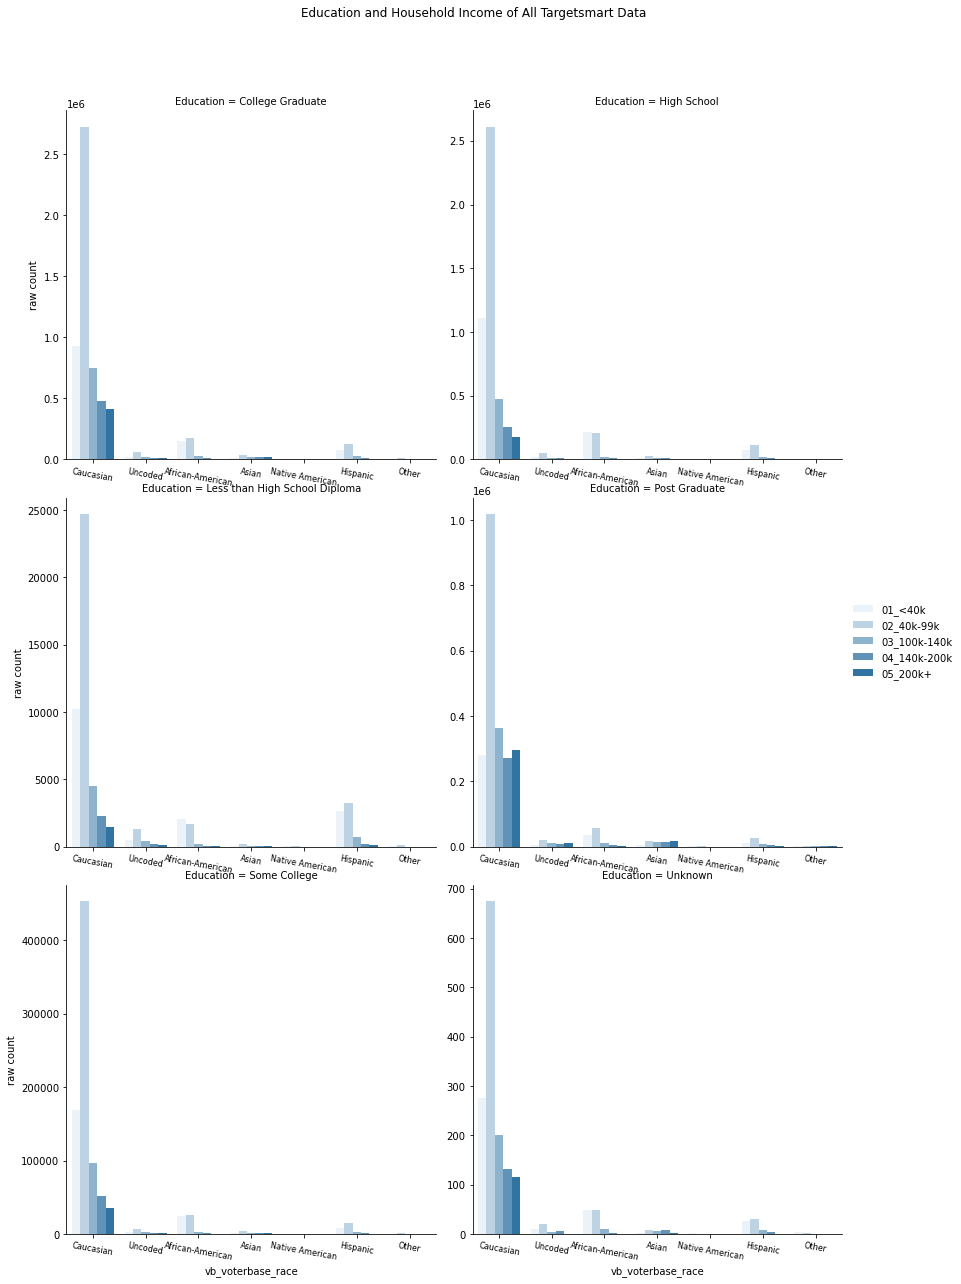

In [39]:
#bar plot to analyze this data
import seaborn as sns
g = sns.FacetGrid(income_analysis, col="Education",size=6, aspect=1,margin_titles=True,col_wrap=2,sharey=False,sharex=False)
g.map(sns.barplot, "vb_voterbase_race", "raw count", 'hh_income', order=['Caucasian', 'Uncoded', 'African-American', 'Asian',
       'Native American', 'Hispanic', 'Other'])
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Education and Household Income of All Targetsmart Data')
g.set_xticklabels(rotation=-10,fontsize=8)
g.savefig('education.png')




Look at how data is different by education and occupation[tech]

In [48]:
#look at tech jobs:
tech=df[df['Occupation']=='Professional/Technical']
tech.columns
#df.columns

Index(['vb_voterbase_id', 'vb_voterbase_household_id',
       'vb_tsmart_exact_address_track', 'vb_tsmart_latitude',
       'vb_tsmart_longitude', 'vb_tsmart_zip', 'vb_tsmart_state',
       'vb_tsmart_level', 'vb_tsmart_county_name', 'vb_tsmart_county_code',
       'add_type', 'tsmart_geo_confidence', 'vb_voterbase_gender',
       'vb_voterbase_race', 'vb_education', 'tb_education_cd',
       'tb_college_age_flg', 'tb_starting_out_flg', 'tb_career_bldr_flg',
       'tb_prime_earner_flg', 'tb_retiree_flg', 'vb_occupation',
       'tb_occupation_cd', 'xpg_ind_lvl_occupation_code',
       'xpg_ind_lvl_occupation_group', 'hh_income', 'tb_income_range_prem_cd',
       'tb_income_amt', 'xpg_ind_lvl_business_owner',
       'vb_business_owner_indicator', 'vb_business_size_code',
       'vb_business_type', 'vb_business_revenue_range',
       'tb_business_owner_flg', 'tb_boah_flg', 'tb_boah_biz_size_cd',
       'tb_boah_biz_source_cd', 'tb_boah_biz_rank_cd', 'tb_boah_biz_func_cd',
       'tb_boa

In [49]:
#only technical jobs from the large dataset
income_occ_analysis=tech.groupby(['vb_voterbase_race','Education','hh_income'])['hh_income'].count()
income_occ_analysis=income_occ_analysis.to_frame()
income_occ_analysis=income_occ_analysis.rename(columns={'hh_income':'raw count'})
income_occ_analysis=income_occ_analysis.reset_index()
income_occ_analysis.columns

Index(['vb_voterbase_race', 'Education', 'hh_income', 'raw count'], dtype='object')

C:\Users\godin033\Anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\godin033\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


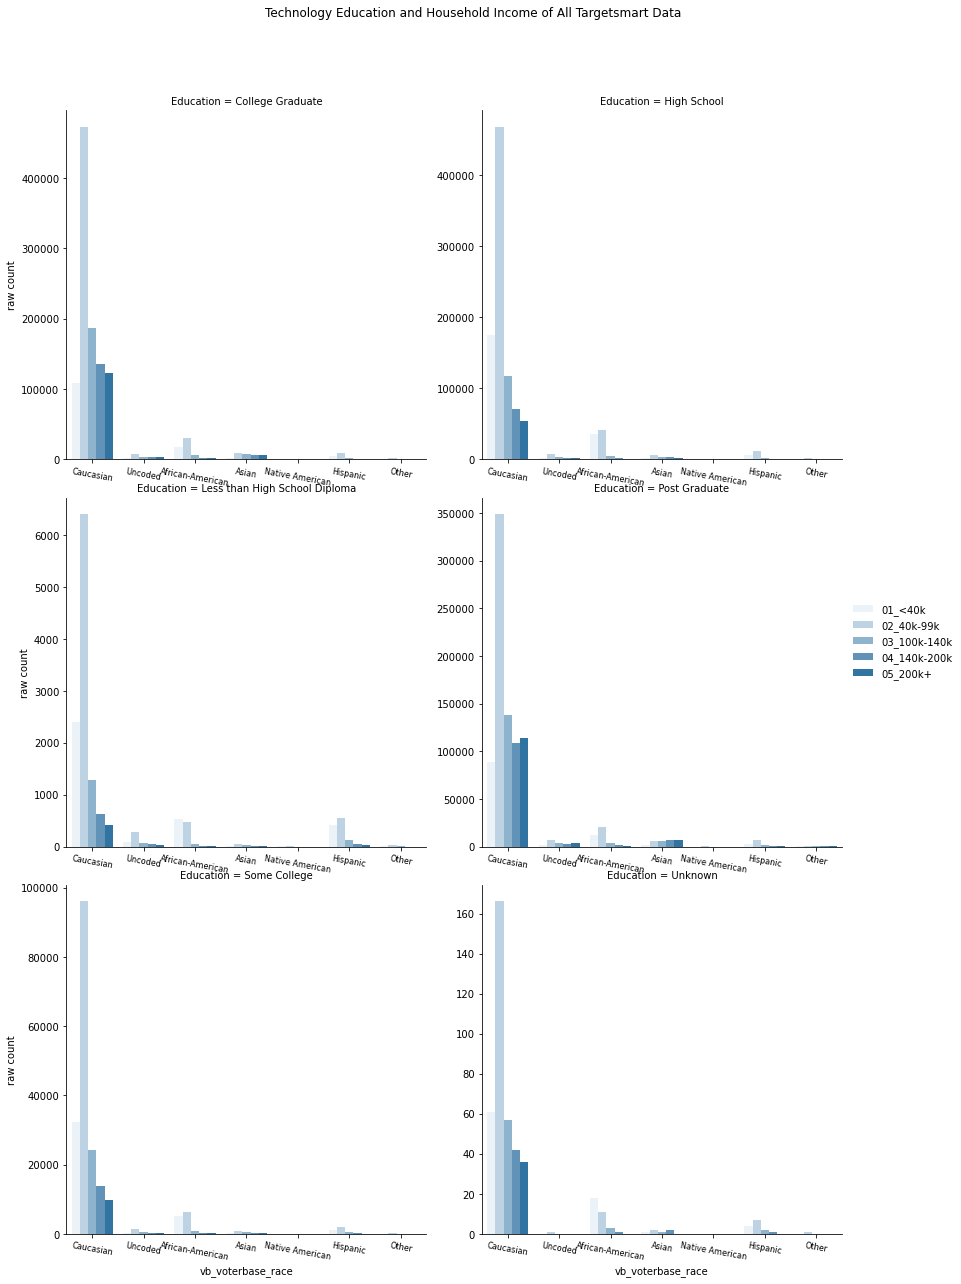

In [50]:
g = sns.FacetGrid(income_occ_analysis, col="Education",size=6, aspect=1,margin_titles=True,col_wrap=2,sharey=False,sharex=False)
g.map(sns.barplot, "vb_voterbase_race", "raw count", 'hh_income', order=['Caucasian', 'Uncoded', 'African-American', 'Asian',
       'Native American', 'Hispanic', 'Other'])
g.add_legend()
g.set_xticklabels(rotation=-10,fontsize=8)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Technology Education and Household Income of All Targetsmart Data')
g.savefig('education_tech.png')

In [51]:
#income by state
income_state_analysis=tech[['vb_voterbase_race','vb_tsmart_state','tb_income_amt']]
income_state_analysis

,vb_voterbase_race,vb_tsmart_state,tb_income_amt
1,Caucasian,AK,124.0
4,Caucasian,AK,120.0
12,Caucasian,AK,350.0
15,Caucasian,AK,163.0
16,Caucasian,AK,875.0
...,...,...,...
16819631,Caucasian,WY,550.0
16819634,Caucasian,WY,65.0
16819645,Caucasian,WY,59.0
16819664,Caucasian,WY,74.0


C:\Users\godin033\Anaconda3\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


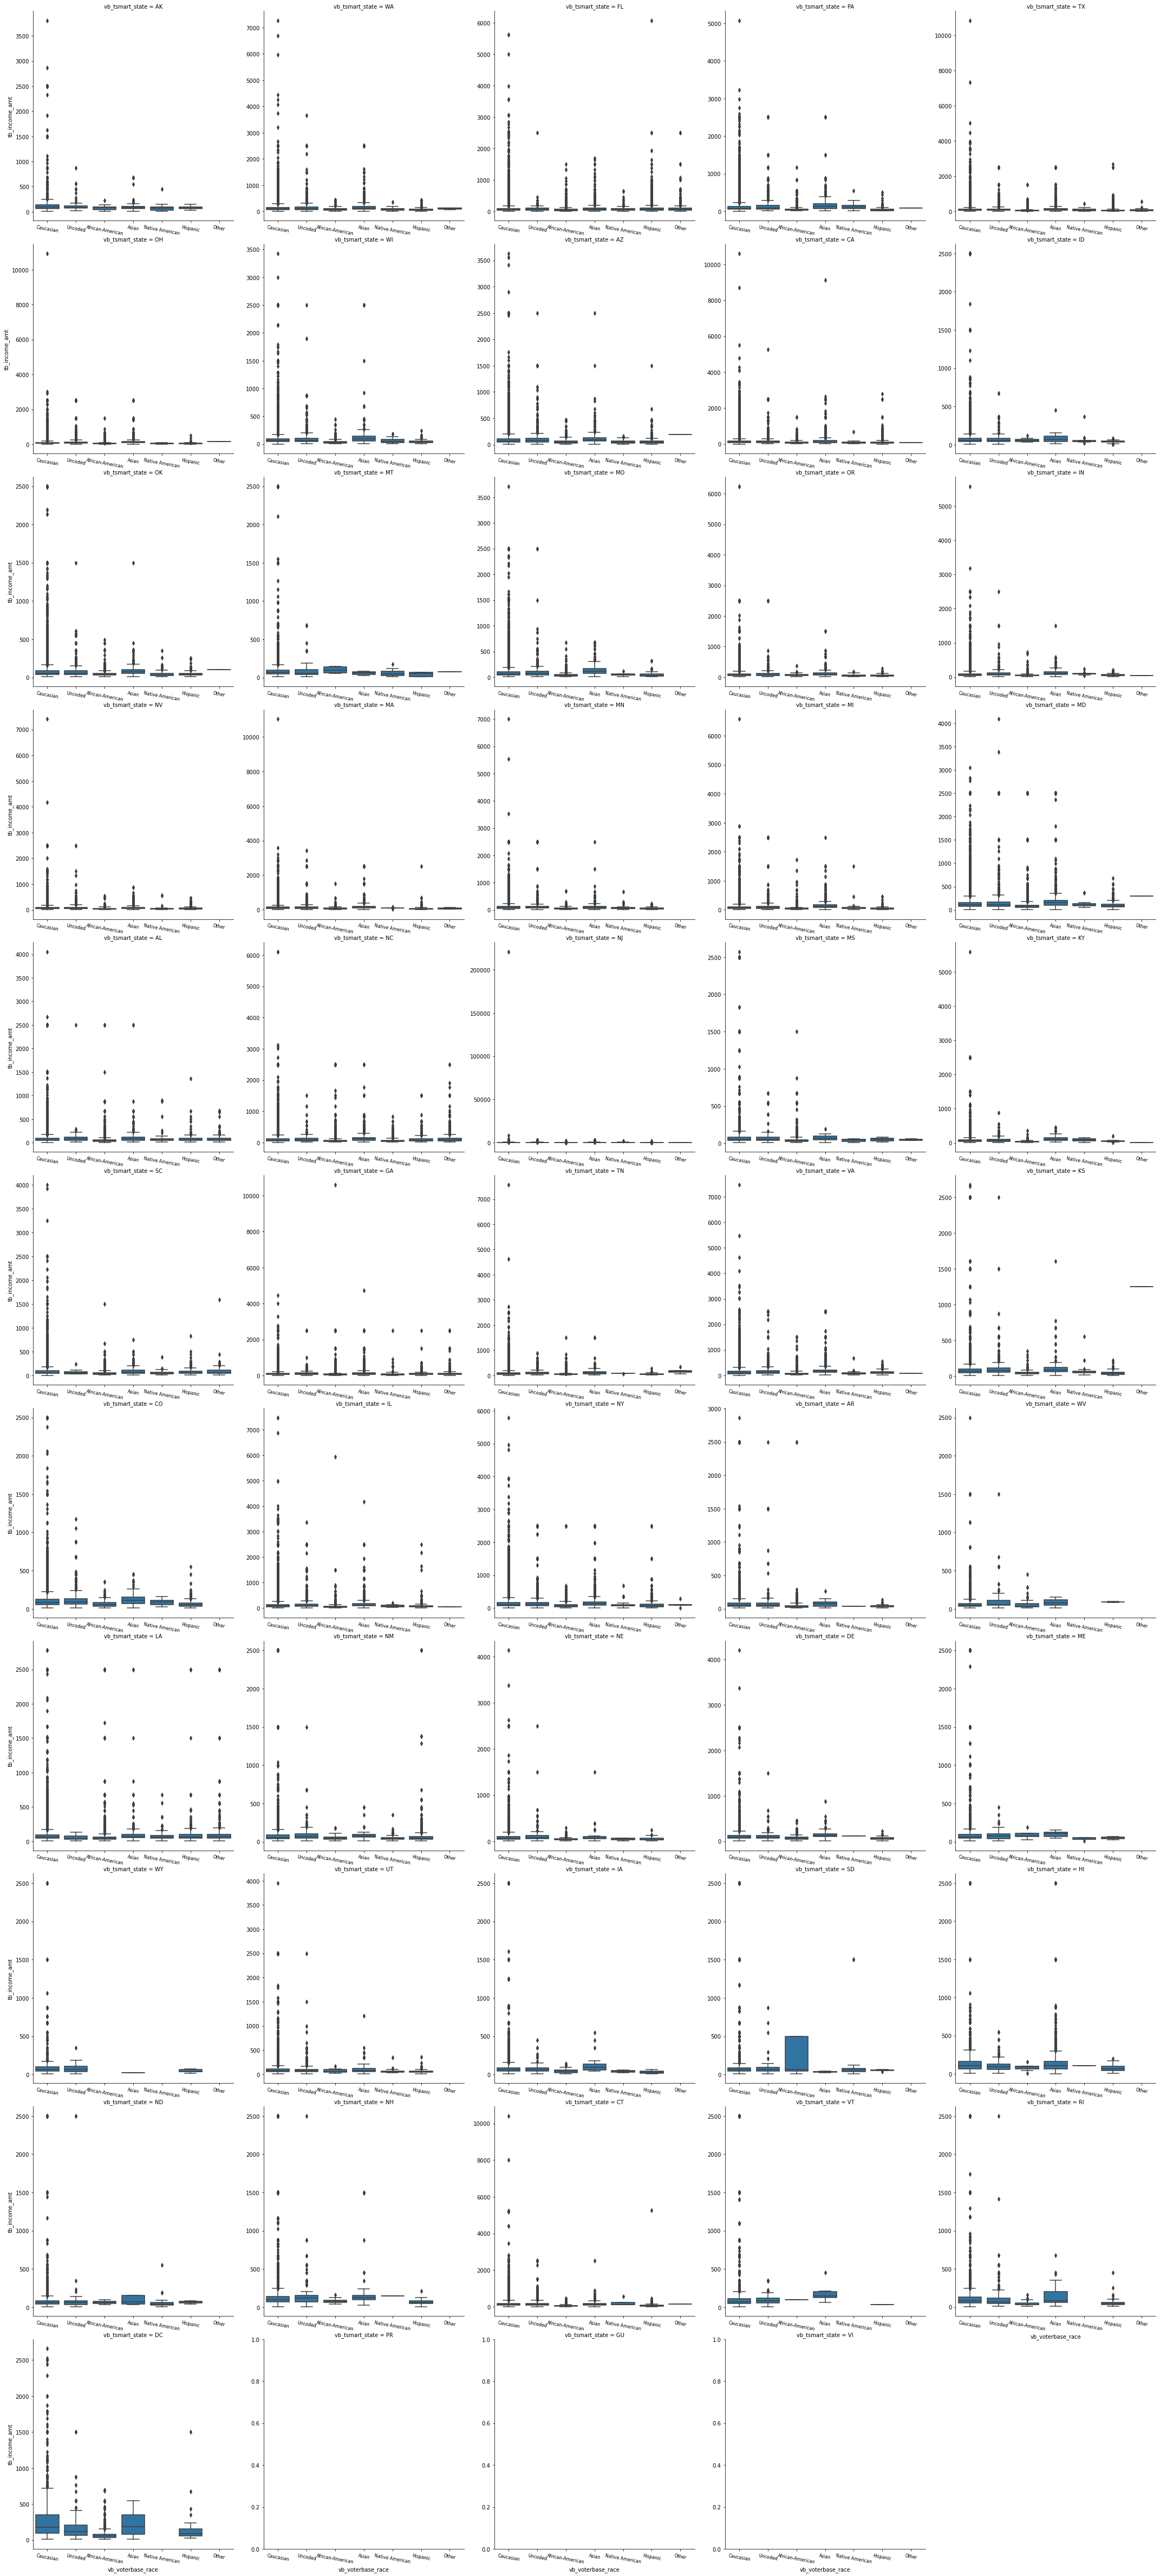

In [55]:
g = sns.FacetGrid(income_state_analysis, col="vb_tsmart_state",size=6, aspect=1,margin_titles=True,col_wrap=5,sharey=False,sharex=False)
g.map(sns.boxplot, "vb_voterbase_race", "tb_income_amt", order=['Caucasian', 'Uncoded', 'African-American', 'Asian',
       'Native American', 'Hispanic', 'Other'])
g.add_legend()
g.set_xticklabels(rotation=-10,fontsize=8)
g.savefig('Income_tech_bystate.png')